# Rarity calculation of NFT collections with Jaccard Distance

This notebook demonstrates calculating rarity scores with Jaccard distance of each individual NFT in a collection.

In [164]:
import json

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import (
    pdist,
    squareform
)

## Example use-case
Let's start with simple collection. We will examine rarity of each character


In [185]:
characters = [
    { 'name': 'Thorr Moddon',
      'id': 0,
      'attributes' :[{'trait_type': 'Body Armor', 'value': 'Worn Chain'},
                      {'trait_type': 'Weapon', 'value': 'Iron Sword'},
                      {'trait_type': 'Shoulder', 'value': 'Ogre'},
                      {'trait_type': 'Amulet', 'value': 'Copper'}]
    },
    { 'name': 'Marmy Onrett',
      'id': 1,
      'attributes' :[{'trait_type': 'Body Armor', 'value': 'Worn Chain'},
                      {'trait_type': 'Weapon', 'value': 'Iron Sword'},
                      {'trait_type': 'Shoulder', 'value': 'Barbaric'},
                      {'trait_type': 'Amulet', 'value': 'Copper'}]
    },
    { 'name': 'Sassayl Delron',
      'id': 2,
      'attributes' :[{'trait_type': 'Body Armor', 'value': 'Draconic'},
                      {'trait_type': 'Weapon', 'value': 'Mihtril Axe'},
                      {'trait_type': 'Shoulder', 'value': 'Barbaric'},
                      {'trait_type': 'Amulet', 'value': 'Copper'}]
    }
]

### Create pandas.DataFrame from characters metadata

In [197]:
def create_nft_collection_df(nft_collection):
    """
    creates pandas.DataFrame from raw NFT collection data.
    """
    
    def get_attributes_as_df(nft_item):
        """
        transformer function that transforms single NFT item 
        into pandas.DataFrame
        """
        attributes = pd.DataFrame.from_records(nft_item['attributes'])
        attributes['nft_name'] = nft_item['name']
        attributes['nft_id'] = nft_item['id']
        return attributes


    nft_attr = pd.concat([get_attributes_as_df(nft_item) for nft_item in nft_collection])
    nft_attr = nft_attr.reset_index().drop('index', axis=1)

    nft_attr['attr_id'] = nft_attr.groupby(["trait_type", "value"]).ngroup()
    return nft_attr

In [198]:
character_attrs_df = create_nft_collection_df(characters)
character_attrs_df.head(20)

,trait_type,value,nft_name,nft_id,attr_id
0,Body Armor,Worn Chain,Thorr Moddon,0,2
1,Weapon,Iron Sword,Thorr Moddon,0,5
2,Shoulder,Ogre,Thorr Moddon,0,4
3,Amulet,Copper,Thorr Moddon,0,0
4,Body Armor,Worn Chain,Marmy Onrett,1,2
5,Weapon,Iron Sword,Marmy Onrett,1,5
6,Shoulder,Barbaric,Marmy Onrett,1,3
7,Amulet,Copper,Marmy Onrett,1,0
8,Body Armor,Draconic,Sassayl Delron,2,1
9,Weapon,Mihtril Axe,Sassayl Delron,2,6


### Generate one-hot encoded attributes DataFrame

In [218]:
def create_one_hot_encoded_attributes(attrs_df):
    """
    creates one-hot encoded row-vectors for each NFT item in the collection.
    
    output shape: (N, m) where;
      N: Total NFT items in the collection
      m: # of unique attributes in the collection
      
    """
    
    total_trait = attrs_df['attr_id'].nunique()

    def create_one_hot_encoded_vector(trait_ids):
        trait_vector = pd.Series([False] * total_trait)
        trait_vector[trait_ids] = True
        return trait_vector
    
    return attrs_df.groupby('nft_id')['attr_id'].apply(create_one_hot_encoded_vector).unstack(level=1)

In [221]:
one_hot_encoded_characters = create_one_hot_encoded_attributes(character_attrs_df)
one_hot_encoded_characters.head()

,0,1,2,3,4,5,6
nft_id,,,,,,,
0,True,False,True,False,True,True,False
1,True,False,True,True,False,True,False
2,True,True,False,True,False,False,True


### Calculate Jaccard distance matrix
One-hot encoded attributes data frame can be fed into Jaccard distance calculation function

In [170]:
j_distances = 1 - pdist(one_hot_encoded_characters, 'jaccard')
j_distances

array([0.6       , 0.14285714, 0.33333333])

In [171]:
j_distances_df = pd.DataFrame(squareform(j_distances))
j_distances_df.head()

,0,1,2
0,0.000000,0.600000,0.142857
1,0.600000,0.000000,0.333333
2,0.142857,0.333333,0.000000


**Calculate Jaccard Score**

Jaccard scores of each NFT are calculating by averaging it's distances to other NFT's in the collection

In [205]:
j_scores = j_distances_df.agg('mean').sort_values()
j_scores.head()

2    0.158730
0    0.247619
1    0.311111
dtype: float64

**Normalize Jaccard scores**

Jaccard scores are normalized between 0 and 100. Less the Jaccard score rarer the NFT

In [219]:
j_scores = ((j_scores - j_scores.min()) / (j_scores.max() - j_scores.min())) * 100
j_scores.head()

2      0.000000
0     58.333333
1    100.000000
dtype: float64

**Abstract above steps in a single function**

In [201]:
def calculate_jaccard_score(one_hot_encoded_df):
    j_distances = 1 - pdist(one_hot_encoded_df, 'jaccard')
    j_distances_df = pd.DataFrame(squareform(j_distances))
    j_scores = j_distances_df.agg('mean').sort_values()
    # normalize between 0 and 100
    j_scores = ((j_scores - j_scores.min()) / (j_scores.max() - j_scores.min())) * 100 
    return j_scores

## Working with NFT Collection data

`rarity_score_pipeline` function receives a collection name and executes all the steps consequtively to calculate rarity scores.

In [202]:
def rarity_score_pipeline(collection_name):
    """
    executes sequential operations to calculate rarity scores 
    based on jaccard distance
    
    |--> loads .json file
    |--> creates pandas.DataFrame from json
    |--> creates one-hot encoded attributes DataFrame
    |--> calculates pair-wise Jaccard distance matrix
        |--> aggregates pair-wise Jaccard distances to calculate 
              rarity score for each NFT
        |--> normalizes rarity scores between 0 and 100
        |--> sort NFT's w.r.t rarity score
    |--> visualize rarity curve and histogram.
    
    returns
    |--> nft_attrs_df from 2nd step
    |--> one_hot_attrs_df from 3rd step
    |--> jaccard_scores from 4th step
    
    """
    
    with open(f'{collection_name}.json', 'rb') as fp:
        nft_collection = json.load(fp)
        
    nft_attrs_df = create_nft_collection_df(nft_collection)
    
    one_hot_attrs_df = create_one_hot_encoded_attributes(nft_attrs_df)
    
    jaccard_scores = calculate_jaccard_score(one_hot_attrs_df)
    
    fig, ax = plt.subplots(2,1)
    fig.tight_layout()
    sns.lineplot(jaccard_scores.values, ax=ax[0]).set_title(f'Rarity curve of {collection_name}')
    sns.histplot(jaccard_scores.values, kde=True, ax=ax[1]).set_title(f'Rarity distribution of {collection_name}')
    return nft_attrs_df, one_hot_attrs_df, jaccard_scores

## Working with the real NFT collection data


---
### Analyzing rarity of Bored Ape Yatch Club collection

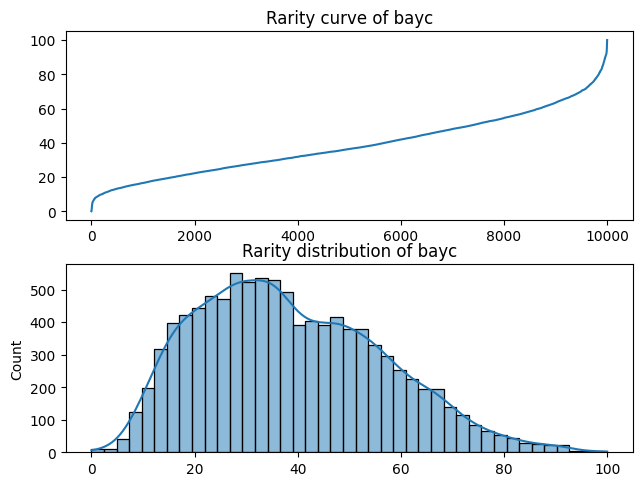

In [222]:
bayc_results =  rarity_score_pipeline('bayc')

In [223]:
bayc_results[2].head(10)

2488    0.000000
6269    0.032102
2794    0.666486
6207    0.900243
7156    1.274097
5597    1.342244
5486    1.425762
7495    2.013176
146     2.132710
9234    2.578730
dtype: float64

### Analyzing rarity of Moonbirds collection

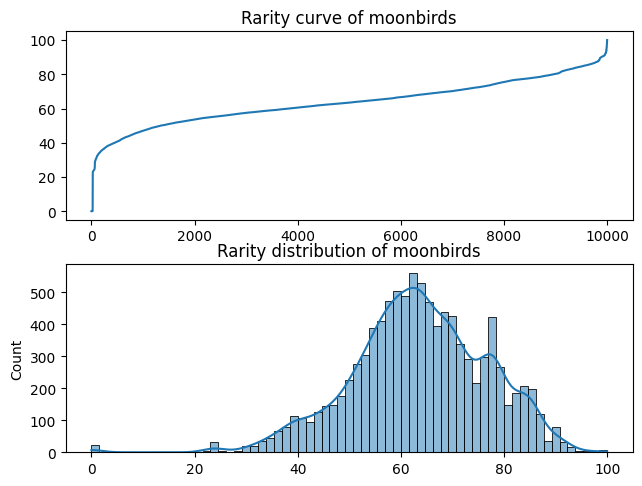

In [210]:
moonbirds_results =  rarity_score_pipeline('moonbirds')

In [224]:
moonbirds_results[2].head(10)

4089    0.000000e+00
2941    0.000000e+00
668     0.000000e+00
1729    0.000000e+00
8398    0.000000e+00
5079    0.000000e+00
7473    0.000000e+00
4835    6.998484e-17
2642    4.059966e-02
2290    4.059966e-02
dtype: float64

### Analyzing rarity of Azuki collection

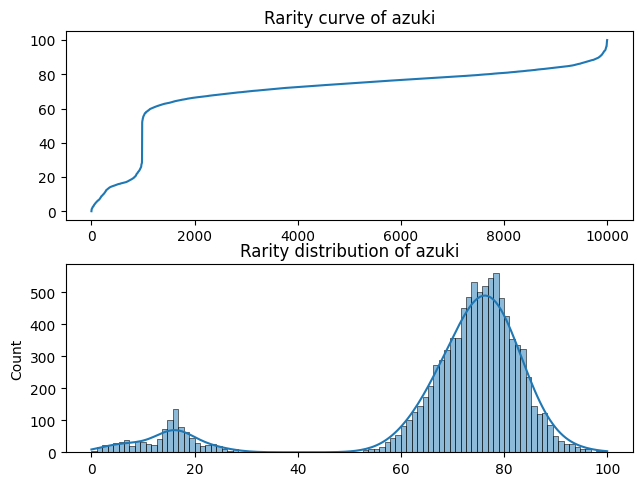

In [213]:
azuki_results =  rarity_score_pipeline('azuki')

In [217]:
azuki_results[2].head(10)

2287    0.000000
3140    0.552068
1836    0.850117
9914    0.993020
3266    1.114328
4666    1.219624
641     1.302724
6525    1.320907
4690    1.418827
2445    1.467231
dtype: float64